In [34]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [35]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [37]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [38]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(engine, reflect=True)


In [39]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [42]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [43]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for matching dates from the previous year

trip_dates = calc_temps('2017-08-01', '2017-08-07')

In [44]:
trip_dates

[(72.0, 79.25, 83.0)]

In [45]:
df = pd.DataFrame(trip_dates, columns = ['TMIN', 'TAVE', 'TMAX'])

In [46]:
TMIN = df.TMIN[0]
TAVE = df.TAVE[0]
TMAX = df.TMAX[0]

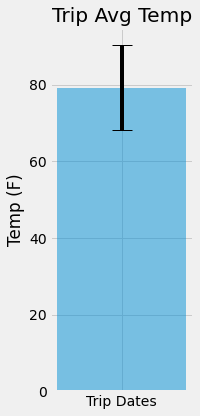

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=(3, 6))
ax.bar("Trip Dates", TAVE, yerr=(TMAX- TMIN), align='center', alpha=0.5, ecolor='black', capsize=10, width=0.2)
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')
plt.tight_layout()
plt.show();


### Daily Rainfall Average

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-08-01'
end_date = '2017-08-07'
rainfall = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.longitude, Station.latitude, Station.elevation).\
                    filter(Measurement.station== Station.station).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= start_date).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) <= end_date).\
                    group_by (Measurement.station). order_by (func.sum(Measurement.prcp).desc()).\
                    all()

for station in rainfall:
    print(station)


('USC00516128', 0.36, 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 152.4)
('USC00514830', 0.22, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', -157.8374, 21.5213, 7.0)
('USC00519281', 0.06, 'WAIHEE 837.5, HI US', -157.84888999999998, 21.45167, 32.9)
('USC00519397', 0.04, 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0)
('USC00519523', 0.0, 'WAIMANALO EXPERIMENTAL FARM, HI US', -157.71139, 21.33556, 19.5)


### Daily Temperature Normals

In [49]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [50]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates

trip_dates=pd.date_range(start=start_date,end=end_date)

# Strip off the year and save a list of strings in the format %m-%d
date_list=[str(dt.datetime.strftime(date,'%m-%d')) for date in trip_dates]
date_list

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for date in date_list:
    normal=daily_normals(date)
    normals.append(list(np.ravel(normal)))
normals




[[67.0, 75.54, 83.0],
 [68.0, 75.60377358490567, 84.0],
 [70.0, 76.61111111111111, 85.0],
 [69.0, 76.71153846153847, 84.0],
 [69.0, 76.14814814814815, 82.0],
 [67.0, 76.25, 83.0],
 [71.0, 77.15686274509804, 83.0]]

In [51]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df = pd.DataFrame(normals, index=trip_dates, columns=['TMIN','TAVG','TMAX'])
df

,TMIN,TAVG,TMAX
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


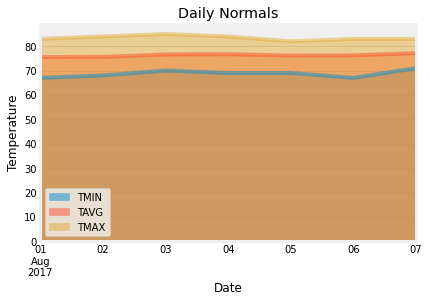

In [52]:
# Plot the daily normals as an area plot with `stacked=False`

%matplotlib inline
df.plot.area(stacked=False)
plt.title('Daily Normals')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

## Close Session

In [53]:
# Close Session
session.close()